In [1]:
import json
import os
import numpy as np
from typing import Dict, Tuple, List, Set, Iterator, Union
import glob
import argparse
import shutil
import multiprocessing as mp
from detectron2.data import transforms as T
from functools import partial
from pathlib import Path
import tifffile as tf
import matplotlib.pyplot as plt
from matplotlib import patches
import re

In [2]:
class AnnoUtil:
    
    def __init__(self, annotation_file: str):

        ##TODO: if annotation_file is None, handle error
        
        """A class to hold image annotations with
        convenience functions to parse various attributes
        such as bounding box coordinates, annotation types, etc..

        Args:
        annotation_file -- full path to the json annotation
        """
        with open(annotation_file) as jFile:
            self.image_annotations = json.load(jFile)
            
    def search_recursive(self, d: Dict, key: str) -> Iterator:
            """Helper function for finding which level of json annotations has
            the matching key.
            """
            for k, v in d.items():
                if isinstance(v, Dict):
                    for match in self.search_recursive(v, key):
                        yield match
                if k == key:
                    # generator function - saves in memory until called
                    # (use for loop to call)
                    yield v
    
    def find_bbox_coordinates(self, annotation_instance: Dict) -> Dict[str, List]:
        """Find and return the coordinates for an annotated bounding box.
        Args:
        annotation_instance -- annotation for one bounding box
        Return:
        bbox_dict -- A Dict of [ROI type, list of bbox coordinates in XYXY]
        """
        box_name = self.get_box_name(annotation_instance)
        # box_coord = annotation_instance["geometry"]["coordinates"]
        if box_name:
            box_coord = next(self.search_recursive(annotation_instance, "coordinates"))
            if len(box_coord) == 1: # Some polygons are broken into multiple sub-lists; this is a bandaid fix
                box_arr = np.array(box_coord[0])
                bbox = [
                    min(box_arr[:, 0]),
                    min(box_arr[:, 1]), 
                    max(box_arr[:, 0]),
                    max(box_arr[:, 1]),
                ]
                bbox_dict = {box_name: bbox}
                return bbox_dict
            else:
                pass
        else:
            pass
        
    def get_box_name(self, annotation_instance: Dict) -> str:
        """Find and return the name of an annotated bounding box.

        Args:
        annotation_instance -- annotation for one bounding box
        Return:
        box_name -- the annotated name of the box
        """
        # Pass on polygons
        num_vertices = len(next(self.search_recursive(annotation_instance, "coordinates"))[0])
        if num_vertices > 5:
            #print("passing", num_vertices)
            return None
        else:
            for properties in self.search_recursive(annotation_instance, "properties"):
                if "name" in properties.keys():
                    property_name = properties["name"].upper()
                    if "ROI" in property_name:
                        cls_name = properties["classification"]["name"].lower()
                        box_name = f"{property_name}_{cls_name}"
                    else:
                        box_name = properties["name"].lower()
                    return box_name
                else:
                    return None
                
    def get_object_name(self, annotation_instance: Dict) -> str:
        """Find and return the name of an annotated mask.

        Args:
        annotation_instance -- annotation for one mask
        Return:
        mask_name -- the annotated name of the mask
        """
        for properties in self.search_recursive(annotation_instance, "properties"):
            if "name" in properties.keys():
                property_name = properties["name"].upper()
                mask_name = property_name
            else:
                try:
                    mask_name = properties["classification"]["name"].lower()
                except:
                    mask_name = None
            return mask_name
            
    def find_poly_coordinates(self, annotation_instance: Dict)  -> Dict[str, List]:
        """Find and return the coordinates for an annotated polygon.
        Args:
        annotation_instance -- annotation for one polygon
        Return:
        poly_dict -- A Dict of [ROI type, list of polygon coordinates in XYXY pairs]
        """
        poly_name = self.get_object_name(annotation_instance)
        if poly_name:
            poly_coord = next(self.search_recursive(annotation_instance, "coordinates"))
            poly_arr = np.array(poly_coord[0])
            poly_dict = {poly_name: poly_arr}
            return poly_dict
        else:
            pass
        
    def parse_bboxes(self) -> List[Dict]:
        """Parse bbox coordinates into detectron2's expected format: BoxMode.XYXY_ABS;
        expect image_annotations in QuPath's exported format.
        return:
        bbox_list = a list of single-length dicts
                    each dict's key is the classification
                    each value is bbox coordinates in [XYXY]
        """
        bbox_list = []
        if not isinstance(self.image_annotations, list):
            image_annotations = [self.image_annotations]
        else:
            image_annotations = self.image_annotations
        for i in image_annotations:
            bbox_dict = self.find_bbox_coordinates(i)
            # Skip if no bbox_dict can be parsed
            if not bbox_dict:
                pass
            # Check if key for bbox_dict is not None
            elif list(bbox_dict.keys())[0]:
                bbox_list.append(bbox_dict)
        return bbox_list
    
    def parse_polygons(self) -> List[Dict]:
        polygon_list = []
        if not isinstance(self.image_annotations, list):
            image_annotations = [self.image_annotations]
        else:
            image_annotations = self.image_annotations
        for i in image_annotations:
            print(i)
            poly_dict = self.find_poly_coordinates(i)
            # Skip if no poly_dict can be parsed
            if not poly_dict:
                pass
            # Check if key for poly_dict is not None
            elif list(poly_dict.keys())[0]:
                polygon_list.append(poly_dict)
        return polygon_list

In [3]:
def lymph_nonlymph_annos(anno_path: str, scale_factor: float) -> List:
    #get lymph and non-lymph annotations
    anno_helper = AnnoUtil(anno_path)
    bbox_dicts = anno_helper.parse_bboxes()
    anno_list = []
    for i in bbox_dicts:
        try:
            lymph_coords = [int(x * scale_factor) for x in i['lymph']]
            lymph_dict = {'lymph' : lymph_coords}
            anno_list.append(lymph_dict)
        except:
            pass
        try:
            nonlymph_coords = [int(x * scale_factor) for x in i['non-lymph']]
            nonlymph_dict = {'non-lymph' : nonlymph_coords}
            anno_list.append(nonlymph_dict)
        except:
            pass
        
    return anno_list

def class_conversion_annos(class_path: str, anno_path: str, scale_factor: float) -> List:
    # get all annos that exist in class conversions file 
    with open(class_path) as f:
        class_conversions = json.load(f)
    anno_helper = AnnoUtil(anno_path)
    polygon_dicts = anno_helper.parse_polygons()
    anno_list = []
    for i in polygon_dicts:
        try:
            for key in i.keys():
                if key in class_conversions.keys():
                    coords = [int(x * scale_factor) for x in i[key]]
                    anno_dict = {class_conversions[key] : coords}
                    anno_list.append(anno_dict)
        except:
            pass

def channel_last(input: np.ndarray or tuple) -> np.ndarray or tuple:
    """Return the input in channel-last format
    Args:
    input -- np.ndarray if image or tuple of array.shape
    Return:
    image as ndarray but in channel-last (h, w, c)
    """
    if type(input) == np.ndarray:
        if input.shape[0] == 3:
            return input.transpose(1, 2, 0)
        else:
            return input
    if type(input) == tuple:
        if input[0] == 3:
            return tuple(input[i] for i in [1, 2, 0])
        else:
            return input
        
def resize_image(image, max_dim):
    """
    Args:
    image -- np.ndarray with shape (h, w, c)
    Return:
    resized_image -- np.ndarray with shape (h, w, c)
    """
    h, w = image.shape[:2]
    scale_factor = max_dim / max(h, w)
    new_h = int(h * scale_factor)
    new_w = int(w * scale_factor)
    resized_image = T.ResizeTransform(h, w, new_h, new_w).apply_image(image)
    return resized_image, scale_factor

def vis_image_with_annos(image, annotations, output):
    fig, ax = plt.subplots()
    ax.imshow(image)
    for anno in annotations:
        for name, box in anno.items():
            x1, y1, x2, y2 = box
            w = x2 - x1
            h = y2 - y1
            rect = patches.Rectangle(
                (x1, y1),
                w, h,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)
            ax.annotate(name, (x1, y1), color='b')
        fig.savefig(output)
        plt.close()

In [4]:
def scale_bboxes(bboxes: list, ref_dim, target_dim):
    """Scale bounding boxes in XYXY
    
    Args:
    bboxes -- a list of bboxes in the form [XYXY]
    ref_dim -- (h, w, c) or (h, w)
    target_dim -- ((h, w, c) or (h, w))
    Return:
    scaled_bboxes -- a list of scaled [XYXY]
    """
    x_scale = ref_dim[1] / target_dim[1]
    y_scale = ref_dim[0] / target_dim[0]
    scaled_bboxes = []
    for box in bboxes:
        x0 = int(box[0] / x_scale)
        y0 = int(box[1] / y_scale)
        x1 = int(box[2] / x_scale)
        y1 = int(box[3] / y_scale)
        scaled_bboxes.append([x0, y0, x1, y1])
    return scaled_bboxes

def scale_polygons(polygons: list, ref_dim, target_dim):
    """Scale polygons in XYXY
    
    Args:
    polygons -- a list of polygons in the form [XYXY]
    ref_dim -- (h, w, c) or (h, w)
    target_dim -- ((h, w, c) or (h, w))
    Return:
    scaled_polygons -- a list of scaled [XYXY]
    """
    x_scale = ref_dim[1] / target_dim[1]
    y_scale = ref_dim[0] / target_dim[0]
    scaled_polygons = []
    for poly in polygons:
        scaled_poly = []
        for point in poly:
            x = int(point[0] / x_scale)
            y = int(point[1] / y_scale)
            scaled_poly.append(x)
            scaled_poly.append(y)
        scaled_polygons.append(scaled_poly)
    return scaled_polygons

In [8]:
def main(class_path, out_dir, img_file, **kwargs):
    img_name = os.path.basename(img_file).split('.')[0]
   # print(f"Processing {img_name}...")
    # Find matching annotation json
    max_dim = 2560
    #rescale image so that the longest edge is max_dim
    with tf.TiffFile(img_file) as tiff:
        lvl = 4 #TODO:by default, make this an option
        pyramid_reader = tiff.series[0].levels
        img = pyramid_reader[lvl].asarray()
        print(img.shape)
        if img_file.endswith('.tif'):
            correct_dimensions = (tiff.pages[0].shape[0])
            img = channel_last(img)
        #rescale img to max_dim as longest edge
        img, scaling = resize_image(img, max_dim)
        #print(scaling)
        #annos = class_conversion_annos(class_path, anno_file, true_scale)
        #scale annos to match img
       # print(annos)

    # save image as numpy array
    with open(os.path.join(out_dir, img_name + '.npy'), 'wb') as f:
        np.save(os.path.join(out_dir, img_name + '.npy'), img)

In [10]:
out_dir = '/mnt/MTX/SynologyDrive/GT_2024/LesionFinder/' + 'Cam17_test'
in_dir = '/mnt/MTX/SynologyDrive/' + 'Cam17_test'
class_file = '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/configs/class_conversions/neoplastic.json'

#if not os.path.exists(os.path.join(out_dir, 'tissue_annotations')):
#    os.makedirs(os.path.join(out_dir, 'tissue_annotations'))

print(f"Processing {in_dir}...")
img_files = sorted(glob.glob(os.path.join(in_dir, '*.tif')))
#anno_files = sorted(glob.glob(os.path.join(in_dir, 'qupath_annotations_latest', '*.json')))

for i in range(len(img_files)):
    try:
        main(class_file, out_dir, img_files[i])
    except:
        print(f"Error processing {img_files[i]}")
        continue



Processing /mnt/MTX/SynologyDrive/Cam17_test...
(5184, 7936, 3)
(6240, 11168, 3)
(5728, 10656, 3)
(6240, 8736, 3)
(4608, 6400, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(5152, 6656, 3)
(5600, 7168, 3)
(5376, 7168, 3)
(4704, 6656, 3)
(6272, 7424, 3)
(4160, 5952, 3)
(6240, 8672, 3)
(5664, 11424, 3)
(5728, 8256, 3)
(6016, 12960, 3)
(12326, 6040, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(12326, 6040, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(12326, 6040, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(12326, 6040, 3)
(12326, 6040, 3)
(13161, 5935, 3)
(12326, 6040, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(13161, 5935, 3)
(12326, 604

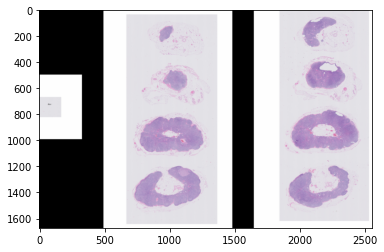

In [11]:
plt.imshow(np.load('/mnt/MTX/SynologyDrive/GT_2024/LesionFinder/Cam17_test/patient_100_node_0.npy'))

In [51]:
# load jsons and append, train test split the list, save as one json

import json
labeled_data = []
unlabeled_data = []
dir1 = ['/mnt/MTX/SynologyDrive/GT_2024/LesionFinder/Cam16_train/qupath_annotations_latest', '/mnt/MTX/SynologyDrive/GT_2024/LesionFinder/Cam16_test/qupath_annotations_latest', '/mnt/MTX/SynologyDrive/GT_2024/LesionFinder/Cam17_train/qupath_annotations_latest']
dir2 = '/mnt/MTX/SynologyDrive/GT_2024/LesionFinder/Cam17_test/qupath_annotations_latest'

for dir in dir1:
    for file in glob.glob(os.path.join(dir, '*.json')):
        with open(file) as f:
            data = json.load(f)
            fname = data['file_name']
            nname = fname.replace('/mnt/MTX/SynologyDrive/', '/mnt/MTX/SynologyDrive/GT_2024/LesionFinder/')
            data['file_name'] = nname
            labeled_data.append(data)
    print(len(labeled_data))
    
for file in glob.glob(os.path.join(dir2, '*.json')):
    with open(file) as f:
        data = json.load(f)
        unlabeled_data.append(data)
print(len(unlabeled_data))

print(labeled_data[0])

716
1132
1296
1398
{'file_name': '/mnt/MTX/SynologyDrive/GT_2024/LesionFinder/Cam16_train/normal_039_0.npy', 'image_id': 'normal_039_0', 'original_width': 96448, 'original_height': 220452, 'tissue_xyxy': [32686, 41491, 64239, 71782], 'width': 2563, 'height': 2460, 'max_dim': 2560, 'annotations': []}


In [42]:
# random split
import random
random.shuffle(labeled_data)

blank_dict = {}
# split all_data into 80 20 split
train_data = labeled_data[:int(0.8 * len(labeled_data))]
test_data = labeled_data[int(0.8 * len(labeled_data)):]

blank_dict['train_labeled'] = train_data
blank_dict['val'] = test_data
blank_dict['train_unlabeled'] = unlabeled_data



with open('/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/dataseed/cam_box.json', 'w') as f:
    json.dump(blank_dict, f, indent=4)